# Getting Setup
This section goes through various steps to get setup for outlier detection. For more details see the ingesting ISIS control networks tutorial.

## Imports

In [2]:
# Required for autocnet imports
import os
os.environ['ISISROOT'] = '/usgs/cpkgs/anaconda3_linux/envs/isis4.2.0'

# Autocnet Imports
from autocnet.graph.network import NetworkCandidateGraph
from autocnet.graph.edge import NetworkEdge
from autocnet.io.db.model import Matches, Points
from autocnet.transformation.roi import Roi

# Helpful Python Modules
import matplotlib.pyplot as plt  #     plotting package
import numpy as np               #     numerical computing package
import pandas as pd              #     data analysis package

## Setting up the NetworkCandidateGraph

### Config

The config various settings that autocnet will use when connecting to other services. Primarily, the config is used to define:

- The database your NetworkCandidateGraph will use
- The redis queue and slurm settings for cluster based processing
- The spatial reference system for geometries such as image footprints

In [3]:
config_path = 'config.yml'

### Loading the control network
This cell will check if the database your config file points to already has a control network ingested in it. If it doesn't then it goes through the steps from the ingesting ISIS control networks tutorial.

In [4]:
data_directory = '/scratch/jmapel/europa'
galileo_net = os.path.join(data_directory, 'networks/GLL_FFCombined_thin_SubReg2_Del_2.net')
galileo_list = os.path.join(data_directory, 'original_cubes.lis')

In [5]:
ncg = NetworkCandidateGraph()
ncg.config_from_file(config_path)
ncg.from_database()
if len(ncg) == 0:
    print(f'Ingesting control network {galileo_net}.')
    ncg = NetworkCandidateGraph.from_cnet(galileo_net, galileo_list, config_path)
else:
    print('Network already in database')

/work/users/jmapel/anaconda_local/envs/autocnet_local/lib/python3.7/site-packages/sqlalchemy/orm/relationships.py:1997: SAWarning: Setting backref / back_populates on relationship Overlay.points to refer to viewonly relationship Points.overlay should include sync_backref=False set on the Overlay.points relationship.  (this warning may be suppressed after 10 occurrences)
  (rel_b, rel_a, rel_b),
/work/users/jmapel/anaconda_local/envs/autocnet_local/lib/python3.7/site-packages/sqlalchemy/orm/relationships.py:1997: SAWarning: Setting backref / back_populates on relationship Points.overlay to refer to viewonly relationship Overlay.points should include sync_backref=False set on the Points.overlay relationship.  (this warning may be suppressed after 10 occurrences)
  (rel_b, rel_a, rel_b),


Network already in database


### Check network
Look at the graph of the network to ensure it isn't malformed. Each image in the network is represented by a node and overlapping images have an edge between their nodes. We will be doing pair-wise outlier detection, so we will check each edge in the network graph

<AxesSubplot:>

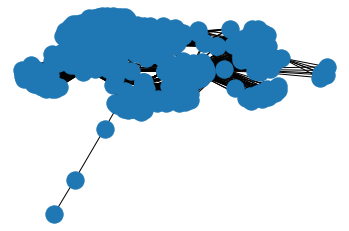

In [6]:
ncg.plot()

### Getting the pairwise image matches
The first process we need to do is collect all of the pairwise matches between images. Our control network currently contains control points and all of the measurements of them. We need to convert these multi-image relationships into all of the common points between each pair of images.

To do this, we're going to use Autocnet's apply function to run parallel processing on each edge of the NetworkCandidateGraph

In [ ]:
for source, dest, edge in ncg.edges_iter(data=True):
    print(f'Matching edge {source} : {dest}')
    edge.network_to_matches()

In [ ]:
?NetworkCandidateGraph.apply

#### SLURM parameters
These parameters will be used when creating SLURM jobs for cluster processing via the apply function. Depending on the complexity of the jobs you are running, you may want to change the walltime and arraychunk parameters.

In [ ]:
walltime="00:30:00"
log_dir = '/scratch/jmapel/autocnet_tut/logs'
arraychunk=75
chunksize=16723

#### Convert control measures and points to image matches
This cell uses apply to run the network_to_matches function on each edge. It is very important that this function only get run once per edge or it will add duplicate matches. So, this cell also contains a check that skips the function if the database already has matches in it.

In [ ]:
?NetworkEdge.network_to_matches

In [ ]:
with ncg.session_scope() as session:
    num_matches = session.query(Matches).count()
if num_matches == 0:
    print("Loading matches table")
    njobs = ncg.apply('network_to_matches', 
                      on='edges',
                      # SLURM kwargs
                      walltime=walltime,
                      log_dir=os.path.join(log_dir, 'matches'),
                      arraychunk=arraychunk,
                      chunksize=chunksize)
else:
    print("Matches table already populated")

### Looking at the matches
The pairwise image matches are stored on the edges of the graph and can be accessed via the networkX graph or the matches table in the database

In [ ]:
for source, dest, edge in ncg.edges(data='data'):
    print(f'Edge ({source}, {dest}) has {len(edge.matches)} matches')

In [ ]:
matches = np.array([len(edge.matches) for _, _, edge in ncg.edges_iter(data=True)])

In [ ]:
plt.boxplot(matches)
plt.show()

## Outlier Detection

### Homography and Reprojective Error
The first computer vision technique that we will apply is called a homography. A homography is a transformation between two planes. In the contect of multi-view imagery, a homography is used when two images observe the same planar surface.

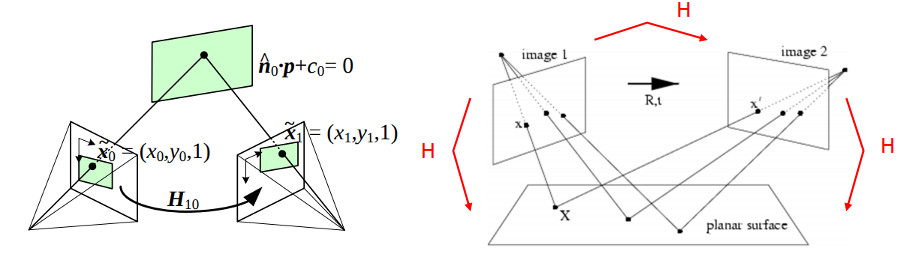

If we can identify points on a planar surface in two images, then we can compute a homography that transforms how the planar surface appears in one image into how the planar surface appears in the other image. Assuming that our surface is roughly planar, we can use our image to image matches to approximate a homography. Then, we can take a measure in one image and transform it into the matching image. Finally, we compare the transformed measure location to the actual measure location and if they vary sufficiently that match is likely incorrect.

In [ ]:
?NetworkEdge.compute_homography

### Fundamental Matrix
The next computer vision technique we will apply is called the fundamental matrix. Similar to a homography, the fundamental matrix describes the relationship between two images that are observing the same thing. Unlike a homography, though, the fundamental matrix does not assume that the two images are observing a planar surface. Instead, the fundamental matrix describes the epipolar geometry between the two images. In short, the epipolar geometry is what lines and points are visible in one image, but occluded in the other.

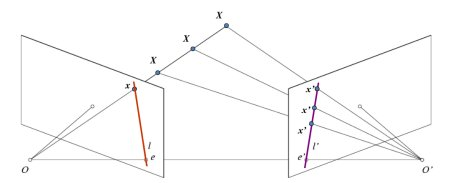

This geometry is another relationship between matching measures that we can use to find potentially bad matches. Unlike a homography, the fundamental matrix is unique for a pair of images. So, we can compute a fundamental matrix for the image pair and then check that all of the matching measures satisfy the fundamental matrix relationship. Because the fundamental matrix describes the 3D relationship between the images, we need more data to compute it. At a minimum we need 8 matches to compute the fundamental matrix, but for robustness, we want at least 16.

In [ ]:
?NetworkEdge.compute_fundamental_matrix

These cells also demonstrate how to pass kwargs through apply. Any kwargs that are not specific to the apply function are passed on to the function being applied.

In [6]:
for source, dest, edge in ncg.edges(data='data'):
    if len(edge.matches) < 20:
        continue
    edge.compute_fundamental_matrix(method="ransac", reproj_threshold=5)
    edge.compute_homography(method="ransac", reproj_threshold=5)

In [ ]:
njobs = ncg.apply('compute_fundamental_matrix', 
                  on='edges',
                  # homography kwargs
                  method='mle',
                  reproj_threshold=5,
                  # SLURM kwargs
                  walltime=walltime,
                  log_dir=os.path.join(log_dir, 'fundamental'),
                  arraychunk=arraychunk,
                  chunksize=chunksize)

In [ ]:
njobs = ncg.apply('compute_homography', 
                  on='edges',
                  # fundamental matrix kwargs
                  method='lmeds',
                  reproj_threshold=5,
                  # SLURM kwargs
                  walltime=walltime,
                  log_dir=os.path.join(log_dir, 'homography'),
                  arraychunk=arraychunk,
                  chunksize=chunksize)

You can check the queue_length property on the NetworkCandidateGraph object to see how many jobs are either waiting to be processed or in process. You can also use the squeue command on a command line or in your notebook to check what jobs slurm has.

In [ ]:
ncg.queue_length

In [ ]:
!squeue -u jmapel

### Looking at the results
The reprojective error checks add a property to each called masks. This is a Pandas dataframe that contains a column for each check that has been done on the edge. If the row for a match has a true in it, then that match passed the column's check. Conversely, if the row for a match has a false in it, then that match failed the column's check. We can use some dataframe techniques to look at our results

In [7]:
match_data = {
    "source": [],
    "dest": [],
    "matches": [],
    "homography": [],
    "fundamental": []
}
for source, dest, edge in ncg.edges(data="data"):
    num_matches = len(edge.matches)
    # MLE requires at least 8 points so skip anything with too few
    if num_matches < 20:
        continue
    match_data["source"].append(source)
    match_data["dest"].append(dest)
    match_data["matches"].append(num_matches)
    match_data["homography"].append(sum(edge.masks['homography']))
    match_data["fundamental"].append(sum(edge.masks['fundamental']))

In [8]:
match_df = pd.DataFrame(data=match_data)
match_df.describe()

,source,dest,matches,homography,fundamental
count,970.000000,970.000000,970.000000,970.000000,970.000000
mean,199.552577,216.230928,129.502062,123.252577,128.481443
std,127.691311,124.492987,133.169951,131.508910,132.620310
min,1.000000,2.000000,20.000000,7.000000,13.000000
25%,80.000000,112.000000,42.000000,40.000000,41.250000
50%,213.500000,225.000000,92.500000,85.000000,92.000000
75%,299.750000,315.000000,152.750000,146.750000,151.750000
max,456.000000,455.000000,954.000000,953.000000,954.000000


In [46]:
match_df["homography_percent"] = match_df["homography"] / match_df["matches"]
match_df["fundamental_percent"] = match_df["fundamental"] / match_df["matches"]
match_df[["homography_percent","fundamental_percent"]]
match_df.sort_values(["homography_percent","fundamental_percent"]).head(20)

,source,dest,matches,homography,fundamental,homography_percent,fundamental_percent
484,3,224,320,83,319,0.259375,0.996875
365,229,3,317,88,317,0.277603,1.000000
435,452,451,21,7,13,0.333333,0.619048
480,3,234,176,66,176,0.375000,1.000000
370,229,2,178,72,178,0.404494,1.000000
815,2,234,55,26,55,0.472727,1.000000
548,19,4,125,63,118,0.504000,0.944000
82,11,229,116,61,116,0.525862,1.000000
666,236,389,87,46,79,0.528736,0.908046
90,11,224,105,56,105,0.533333,1.000000


In [47]:
edge_231_389 = ncg.get_edge_data(231, 389)['data']
edge_231_389.matches[["source_x", "source_y", "destination_x", "destination_y"]]

,source_x,source_y,destination_x,destination_y
id,,,,
72734,251.146,206.073,194.852,575.237
72735,142.886,252.891,630.071,597.4
72736,223.379,223.849,332.887,545.898
72737,179.74,243.457,508.717,550.744
72738,202.639,239.025,443.146,518.842
...,...,...,...,...
72799,249.644,280.711,560.822,223.301
72800,230.786,300.338,692.129,169.802
72801,235.5,262.5,496.166,331.99


### Looking at the matches that failed outlier detection
We can use the masks dataframe to index the matches dataframe on our edge and see the matches that failed each check

In [48]:
failed_homography = edge_231_389.matches.loc[(~edge_231_389.masks['homography'])]
failed_fundamental = edge_231_389.matches.loc[(~edge_231_389.masks['fundamental'])]
failed_both = edge_231_389.matches.loc[(~edge_231_389.masks[['fundamental', 'homography']]).all(axis=1)]

/work/users/jmapel/anaconda_local/envs/autocnet_local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


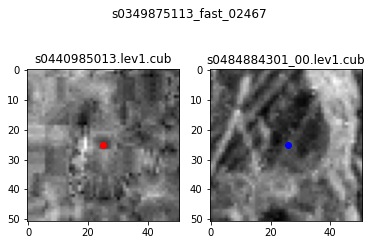

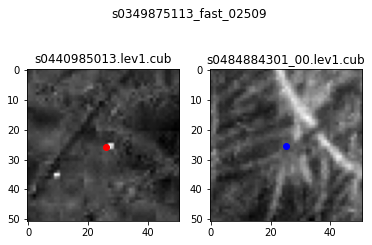

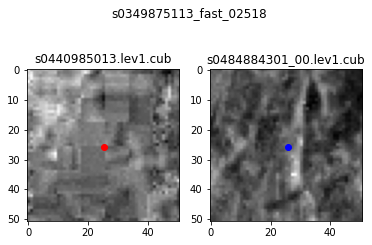

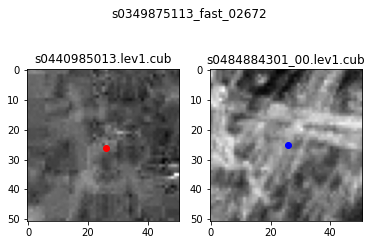

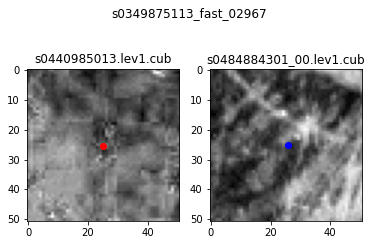

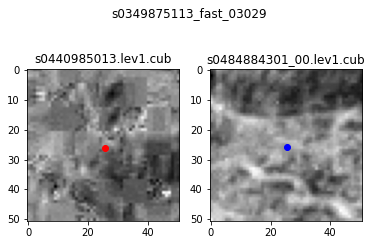

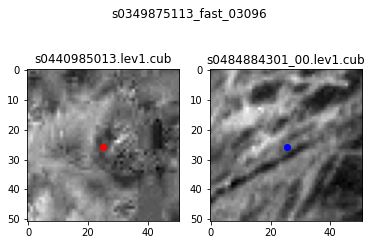

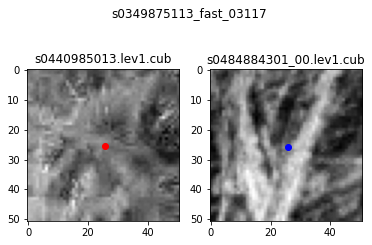

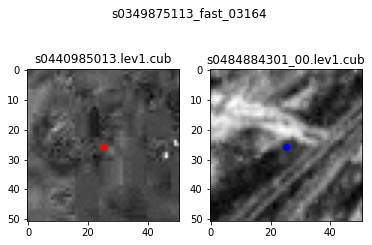

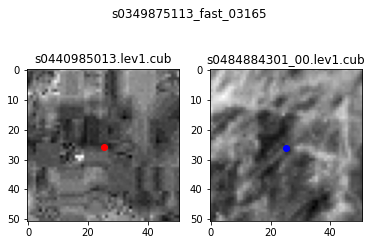

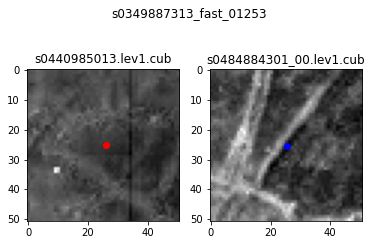

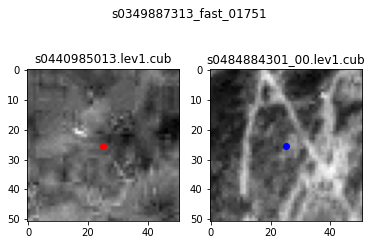

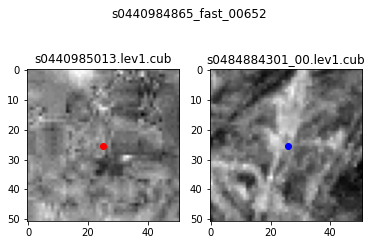

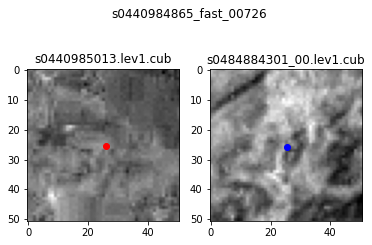

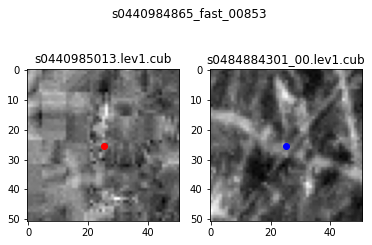

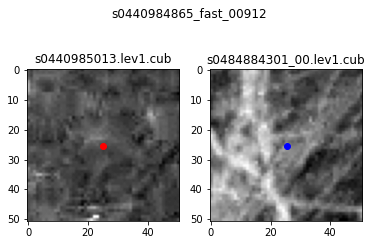

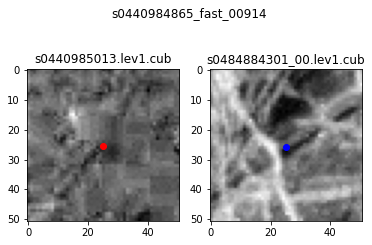

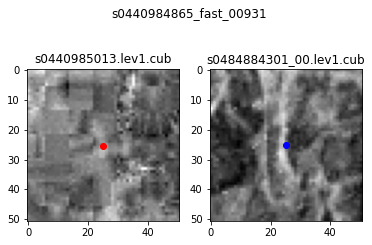

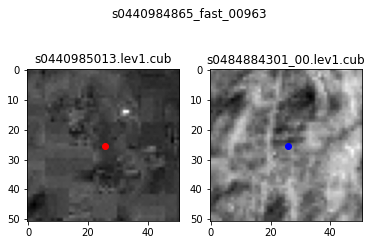

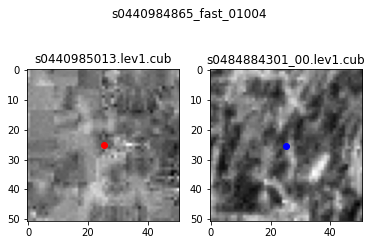

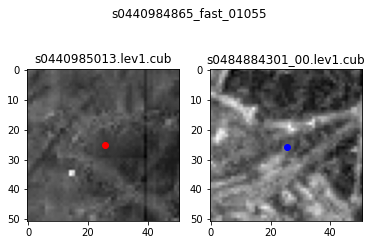

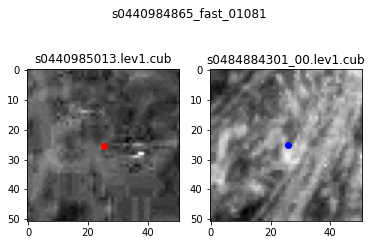

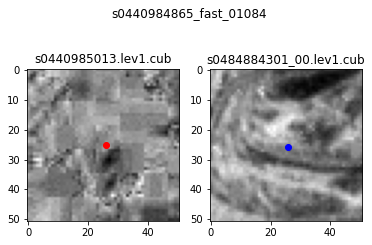

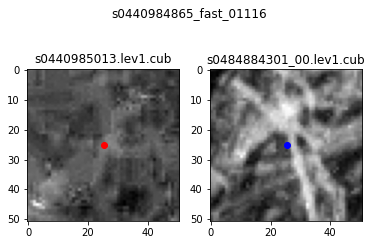

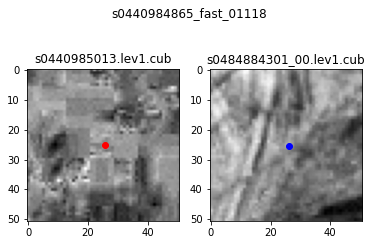

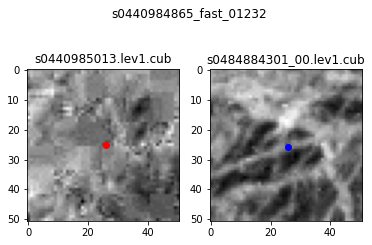

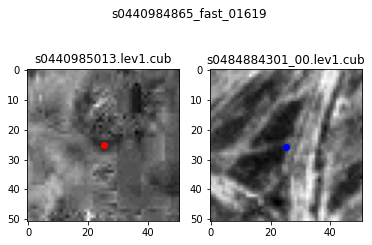

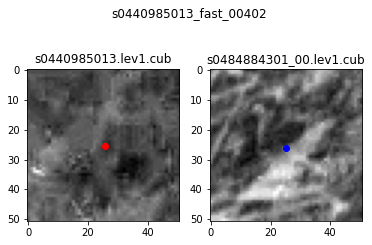

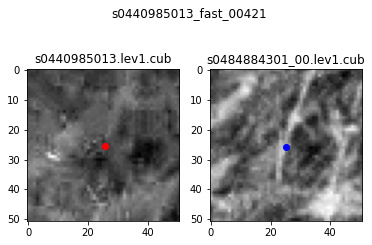

In [49]:
roi_size = 25
for idx, match in failed_homography.iterrows():
    with ncg.session_scope() as session:
        point_name = session.query(Points).filter(Points.id == match["point_id"]).first().identifier

    source_image = ncg.nodes[match['source']]['data']
    dest_image = ncg.nodes[match['destination']]['data']
    source_roi = Roi(source_image.geodata, match['source_x'], match['source_y'], size_x=roi_size, size_y=roi_size)
    dest_roi = Roi(dest_image.geodata, match['destination_x'], match['destination_y'], size_x=roi_size, size_y=roi_size)

    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle(point_name)
    ax1.imshow(source_roi.array, cmap='gray')
    ax1.plot(source_roi.center[0] + source_roi.axr, source_roi.center[1] + source_roi.ayr, 'ro')
    ax1.title.set_text(os.path.split(source_image['image_name'])[-1])
    ax2.imshow(dest_roi.array, cmap='gray')
    ax2.plot(dest_roi.center[0] + dest_roi.axr, dest_roi.center[1] + dest_roi.ayr, 'bo')
    ax2.title.set_text(os.path.split(dest_image['image_name'])[-1])
    fig.show()